In [229]:
import pandas as pd
import os
from nba_api.stats.endpoints import playerindex, playbyplayv3
import utils.data_utils as du
import importlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
HOME_DIR = '/Users/yoav/Documents/Yoav/CS/20936 - DS Project/Shotpred'
DATA_DIR = os.path.join(HOME_DIR, 'data')
EXT_DATA_DIR = os.path.join(DATA_DIR, 'External')
INT_DATA_DIR = os.path.join(DATA_DIR, 'Internal')

In [3]:
KAGGLE_SHOT_LOGS_201415_FILENAME = 'kaggle_shot_logs_2014_15.csv'
KAGGLE_SHOT_LOGS_201415_FULLPATH = os.path.join(EXT_DATA_DIR, KAGGLE_SHOT_LOGS_201415_FILENAME)

GENERAL_SHOT_LOGS_FILENAME = 'nba_2015_shots.csv'
GENERAL_SHOT_LOGS_FULLPATH = os.path.join(EXT_DATA_DIR, GENERAL_SHOT_LOGS_FILENAME)

In [295]:
KAGGLE_COLS_FOR_MERGE = ['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id', 'absolute_game_time']
CAREER_STATS_COL_FOR_MERGE = ['PLAYER_ID', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'] #already filtered for relevant season

In [5]:
shot_logs_1415 = pd.read_csv(KAGGLE_SHOT_LOGS_201415_FULLPATH)

In [6]:
active_players_201415_ids = shot_logs_1415['player_id'].unique()

In [157]:
shot_logs_1415['absolute_game_time'] = shot_logs_1415.apply(lambda row: du.clock_to_absolute_seconds(row['GAME_CLOCK'], row['PERIOD']), axis=1)

In [8]:
#active_players_career_stats = du.gather_mul_career_stats(active_players_201415_ids) # get the career stats for all active players in 2014-15 season

In [9]:
#active_players_cs_in_1415 = active_players_career_stats[active_players_career_stats['SEASON_ID'] == '2014-15'].reset_index(drop=True)
#active_players_cs_in_1415.to_csv(INT_DATA_DIR + 'active_players_career_stats_2014_15.csv', index=False)

In [297]:
active_players_cs_in_1415 = pd.read_csv(os.path.join(INT_DATA_DIR, 'active_players_career_stats_2014_15.csv'))

In [11]:
gen_sl = pd.read_csv(GENERAL_SHOT_LOGS_FULLPATH)

In [12]:
gen_sl.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,04-15-2015,21401229,...,Restricted Area,Center,C,Less Than 8 ft.,-0.4,6.75,1,4,0,18
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,04-15-2015,21401229,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.35,0,4,0,22
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,04-15-2015,21401225,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.35,0,5,0,3
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,04-15-2015,21401229,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.35,0,4,0,37
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,04-15-2015,21401229,...,Mid-Range,Left Side,L,16-24 ft.,16.9,14.85,19,4,0,48


In [158]:
gen_sl['absolute_game_time'] = gen_sl.apply(lambda row: du.clock_to_absolute_seconds(f"{str(row["MINS_LEFT"]).zfill(2)}:{str(row["SECS_LEFT"]).zfill(2)}", row['QUARTER']), axis=1)

In [161]:
kaggle_for_join = shot_logs_1415[KAGGLE_COLS_FOR_MERGE]

In [258]:
kaggle_for_join.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0
2,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0
4,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0


In [17]:
gen_sl_game_ids = set(gen_sl['GAME_ID'].unique())
kaggle_for_join_game_ids = set(kaggle_for_join['GAME_ID'].unique())

common_game_ids = gen_sl_game_ids.intersection(kaggle_for_join_game_ids)

print(f"Number of unique GAME_IDs in gen_sl: {len(gen_sl_game_ids)}")
print(f"Number of unique GAME_IDs in kaggle_for_join: {len(kaggle_for_join_game_ids)}")
print(f"Number of common GAME_IDs in both: {len(common_game_ids)}")

Number of unique GAME_IDs in gen_sl: 1230
Number of unique GAME_IDs in kaggle_for_join: 904
Number of common GAME_IDs in both: 904


In [ ]:
kg = kaggle_for_join.sort_values(by='ABS_TIME').reset_index(drop=True)

In [162]:
kaggle_for_join

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time
0,21400899,10.8,2,1.9,"Anderson, Alan",101187,1.3,203148,651.0
1,21400899,3.4,0,0.8,"Bogdanovic, Bojan",202711,6.1,203148,706.0
2,21400899,NaN,3,2.7,"Bogdanovic, Bojan",202711,0.9,203148,720.0
3,21400899,10.3,2,1.9,"Brown, Markel",203900,3.4,203148,733.0
4,21400899,10.9,2,2.7,"Young, Thaddeus",201152,1.1,203148,806.0
...,...,...,...,...,...,...,...,...,...
128064,21400006,18.3,5,6.2,"Smart, Marcus",203935,0.8,101127,2048.0
128065,21400006,19.8,4,5.2,"Turner, Evan",202323,0.6,101127,2192.0
128066,21400006,23.0,2,4.2,"Thornton, Marcus",201977,4.2,101127,2210.0
128067,21400006,9.1,4,4.5,"Bradley, Avery",202340,3.0,101127,2723.0


In [196]:
kaggle_for_join = kaggle_for_join.sort_values(by=['absolute_game_time']).reset_index(drop=True)

In [194]:
gen_sl = gen_sl.sort_values(by=['absolute_game_time']).reset_index(drop=True)
gen_sl['gen_sl_time_copy'] = gen_sl['absolute_game_time']

In [200]:
merged = pd.merge_asof(kaggle_for_join, gen_sl, on='absolute_game_time',left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'],  direction='nearest', suffixes=['_kaggle', '_shot_logs'], tolerance=5) #,left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'], 

In [207]:
merged.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ABS_TIME,gen_sl_time_copy
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,C,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0,6.0
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,C,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0,9.0
2,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,C,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0,8.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,C,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0,6.0
4,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,C,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0,5.0


In [204]:
not_merged = merged[merged.gen_sl_time_copy.isna()]

In [205]:
not_merged.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ABS_TIME,gen_sl_time_copy
173,21400471,22.9,0,2.1,"Hill, Jordan",201941,2.6,202389,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,21400345,11.6,2,5.0,"Conley, Mike",201144,0.3,203487,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,21400872,11.2,0,0.0,"Amundson, Lou",200811,3.7,202685,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,21400322,10.9,0,4.6,"Joseph, Cory",202709,2.9,101181,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,21400515,9.6,5,4.1,"Holiday, Jrue",201950,5.7,202322,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
not_merged

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ABS_TIME,gen_sl_time_copy
173,21400471,22.9,0,2.1,"Hill, Jordan",201941,2.6,202389,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,21400345,11.6,2,5.0,"Conley, Mike",201144,0.3,203487,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,21400872,11.2,0,0.0,"Amundson, Lou",200811,3.7,202685,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,21400322,10.9,0,4.6,"Joseph, Cory",202709,2.9,101181,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,21400515,9.6,5,4.1,"Holiday, Jrue",201950,5.7,202322,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127143,21400307,24.0,0,3.2,"Griffin, Blake",201933,2.3,200782,3379.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127495,21400288,7.7,1,3.0,"Sims, Henry",203156,3.5,203484,3502.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127581,21400496,9.6,1,1.5,"Gasol, Pau",2200,2.3,202323,3532.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127867,21400302,17.3,0,0.0,"Turner, Evan",202323,5.4,101162,4049.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
not_merged_in_gsg = pd.merge(not_merged, gsg, on=['GAME_ID', 'ABS_TIME', 'PLAYER_ID'], how='left', indicator=True)
#not_merged_in_gsg = not_merged_in_gsg[not_merged_in_gsg['_merge'] == 'both']
not_merged_in_gsg#

,GAME_ID,ABS_TIME,PLAYER_ID,NUMBO,gsg_abs_dup_x,gsg_abs_dup_y,_merge
0,21400345,13.0,203487,NaN,NaN,NaN,left_only
1,21400471,13.0,202389,NaN,NaN,NaN,left_only
2,21400872,14.0,202685,NaN,NaN,NaN,left_only
3,21400322,14.0,101181,NaN,NaN,NaN,left_only
4,21400515,16.0,202322,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...
761,21400307,3379.0,200782,NaN,NaN,NaN,left_only
762,21400288,3502.0,203484,NaN,NaN,NaN,left_only
763,21400496,3532.0,202323,NaN,NaN,NaN,left_only
764,21400302,4049.0,101162,NaN,NaN,NaN,left_only


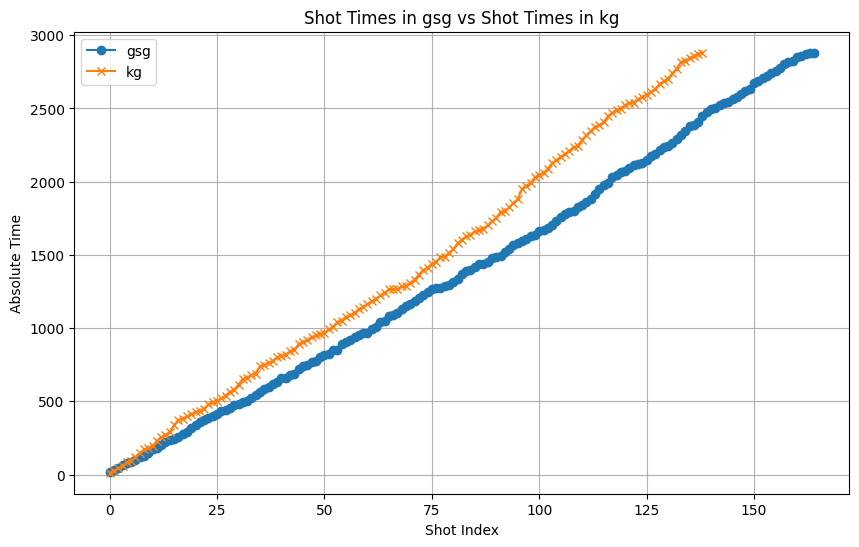

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(gsg['ABS_TIME'], label='gsg', marker='o')
plt.plot(kg['ABS_TIME'], label='kg', marker='x')

plt.xlabel('Shot Index')
plt.ylabel('Absolute Time')
plt.title('Shot Times in gsg vs Shot Times in kg')
plt.legend()
plt.grid(True)

plt.show()

In [208]:
heights = pd.read_csv(os.path.join(INT_DATA_DIR, 'nba_2014_2015_player_heights.csv'))

In [209]:
heights

,PLAYER_NAME,HEIGHT
0,AJ Price,6-2
1,Aaron Brooks,6-0
2,Aaron Gordon,6-8
3,Adreian Payne,6-10
4,Al Horford,6-9
...,...,...
487,Xavier Henry,6-6
488,Zach LaVine,6-5
489,Zach Randolph,6-9
490,Zaza Pachulia,6-11


In [211]:
merged.columns

Index(['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id',
       'absolute_game_time', 'SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME',
       'PLAYER_ID', 'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT',
       'ABS_TIME', 'gen_sl_time_copy'],
      dtype='object')

In [341]:
# Merge for attacker heights
merged_with_attacker_heights = pd.merge(merged, heights, left_on='PLAYER_NAME', right_on='PLAYER_NAME', suffixes=('', '_attacker'))

# Merge for defender heights
merged_with_both_heights = pd.merge(merged_with_attacker_heights, heights, left_on='CLOSEST_DEFENDER', right_on='PLAYER_NAME', suffixes=('_attacker', '_defender'))

# Drop the extra PLAYER_NAME column from the second merge
merged_with_both_heights = merged_with_both_heights.drop(columns=['PLAYER_NAME_defender'])

merged_with_both_heights.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ABS_TIME,gen_sl_time_copy,HEIGHT_attacker,HEIGHT_defender
0,21400579,NaN,0,5.2,Nene,2403,3.1,2200,17.0,2015.0,...,14.6,4.75,14.0,1.0,11.0,40.0,20.0,20.0,7-0,6-11
1,21400776,9.8,0,1.1,Nene,2403,5.7,101112,17.0,2015.0,...,9.5,29.65,26.0,1.0,11.0,41.0,19.0,19.0,7-0,6-11
2,21400179,2.9,1,1.7,Nene,2403,5.8,2544,22.0,2015.0,...,1.3,30.65,25.0,1.0,11.0,36.0,24.0,24.0,6-9,6-11
3,21400427,0.5,2,5.2,Nene,2403,0.1,2405,25.0,2015.0,...,0.7,5.35,0.0,1.0,11.0,37.0,23.0,23.0,6-10,6-11
4,21400656,8.5,2,2.8,Nene,2403,3.1,200746,31.0,2015.0,...,-10.6,16.85,15.0,1.0,11.0,26.0,34.0,34.0,6-11,6-11


In [263]:
heights.head()

,PLAYER_NAME,HEIGHT
0,AJ Price,6-2
1,Aaron Brooks,6-0
2,Aaron Gordon,6-8
3,Adreian Payne,6-10
4,Al Horford,6-9


In [335]:
merged_with_attacker_heights.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ABS_TIME,gen_sl_time_copy,HEIGHT
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0,6.0,6-4
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0,9.0,6-9
2,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0,8.0,6-8
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0,6.0,6-3
4,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0,5.0,6-9


In [342]:
COLS_FOR_PRED = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2', 'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'HEIGHT_attacker', 'HEIGHT_defender']
COLS_FOR_PRED.extend(CAREER_STATS_COL_FOR_MERGE)

# interchange SEASON1/SEASON2
# maybe the game date is highly correlated with season so leave only game date
# probably need to chose only subset of the game time/qtr/mins_left/secs_left features
# SHOT_MADE and EVENT_TYPE is g.t

In [343]:
COLS_FOR_PRED[-9:]

['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT']

In [344]:
cs_for_merge = active_players_cs_in_1415[CAREER_STATS_COL_FOR_MERGE]
for_pred = pd.merge(merged_with_both_heights, cs_for_merge, on='PLAYER_ID')

In [345]:
len(set(list(COLS_FOR_PRED)))

40

In [347]:
for_pred[COLS_FOR_PRED]

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,absolute_game_time,SEASON_1,SEASON_2,TEAM_ID,PLAYER_ID,...,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,NaN,0,5.2,2403,3.1,17.0,2015.0,2014-15,1.610613e+09,2200.0,...,2200.0,570,1153,0.494,12,26,0.462,294,366,0.803
1,9.8,0,1.1,2403,5.7,17.0,2015.0,2014-15,1.610613e+09,101112.0,...,101112.0,191,487,0.392,136,346,0.393,31,35,0.886
2,2.9,1,1.7,2403,5.8,22.0,2015.0,2014-15,1.610613e+09,2544.0,...,2544.0,624,1279,0.488,120,339,0.354,375,528,0.710
3,0.5,2,5.2,2403,0.1,25.0,2015.0,2014-15,1.610613e+09,2405.0,...,2405.0,169,311,0.543,0,3,0.000,94,127,0.740
4,0.5,2,5.2,2403,0.1,25.0,2015.0,2014-15,1.610613e+09,2405.0,...,2405.0,104,179,0.581,0,1,0.000,40,59,0.678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,9.7,16,13.4,2403,2.0,3406.0,2015.0,2014-15,1.610613e+09,200768.0,...,200768.0,430,1043,0.412,132,391,0.338,252,312,0.808
460,6.1,6,4.8,2403,2.1,3417.0,2015.0,2014-15,1.610613e+09,201163.0,...,201163.0,418,975,0.429,139,406,0.342,110,142,0.775
461,7.2,19,17.4,2403,5.2,3452.0,2015.0,2014-15,1.610613e+09,200768.0,...,200768.0,430,1043,0.412,132,391,0.338,252,312,0.808
462,11.4,13,11.0,2403,5.1,3510.0,2015.0,2014-15,1.610613e+09,201951.0,...,201951.0,404,926,0.436,70,205,0.341,265,363,0.730


In [348]:
def visualize_distributions(df):
    """
    Create visualizations for data distributions
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols.drop(['PLAYER_ID', 'CLOSEST_DEFENDER_PLAYER_ID', 'SEASON_1'])
    
    # Distribution plots for numerical columns
    plt.figure(figsize=(15, 5 * (len(numerical_cols) // 3 + 1)))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

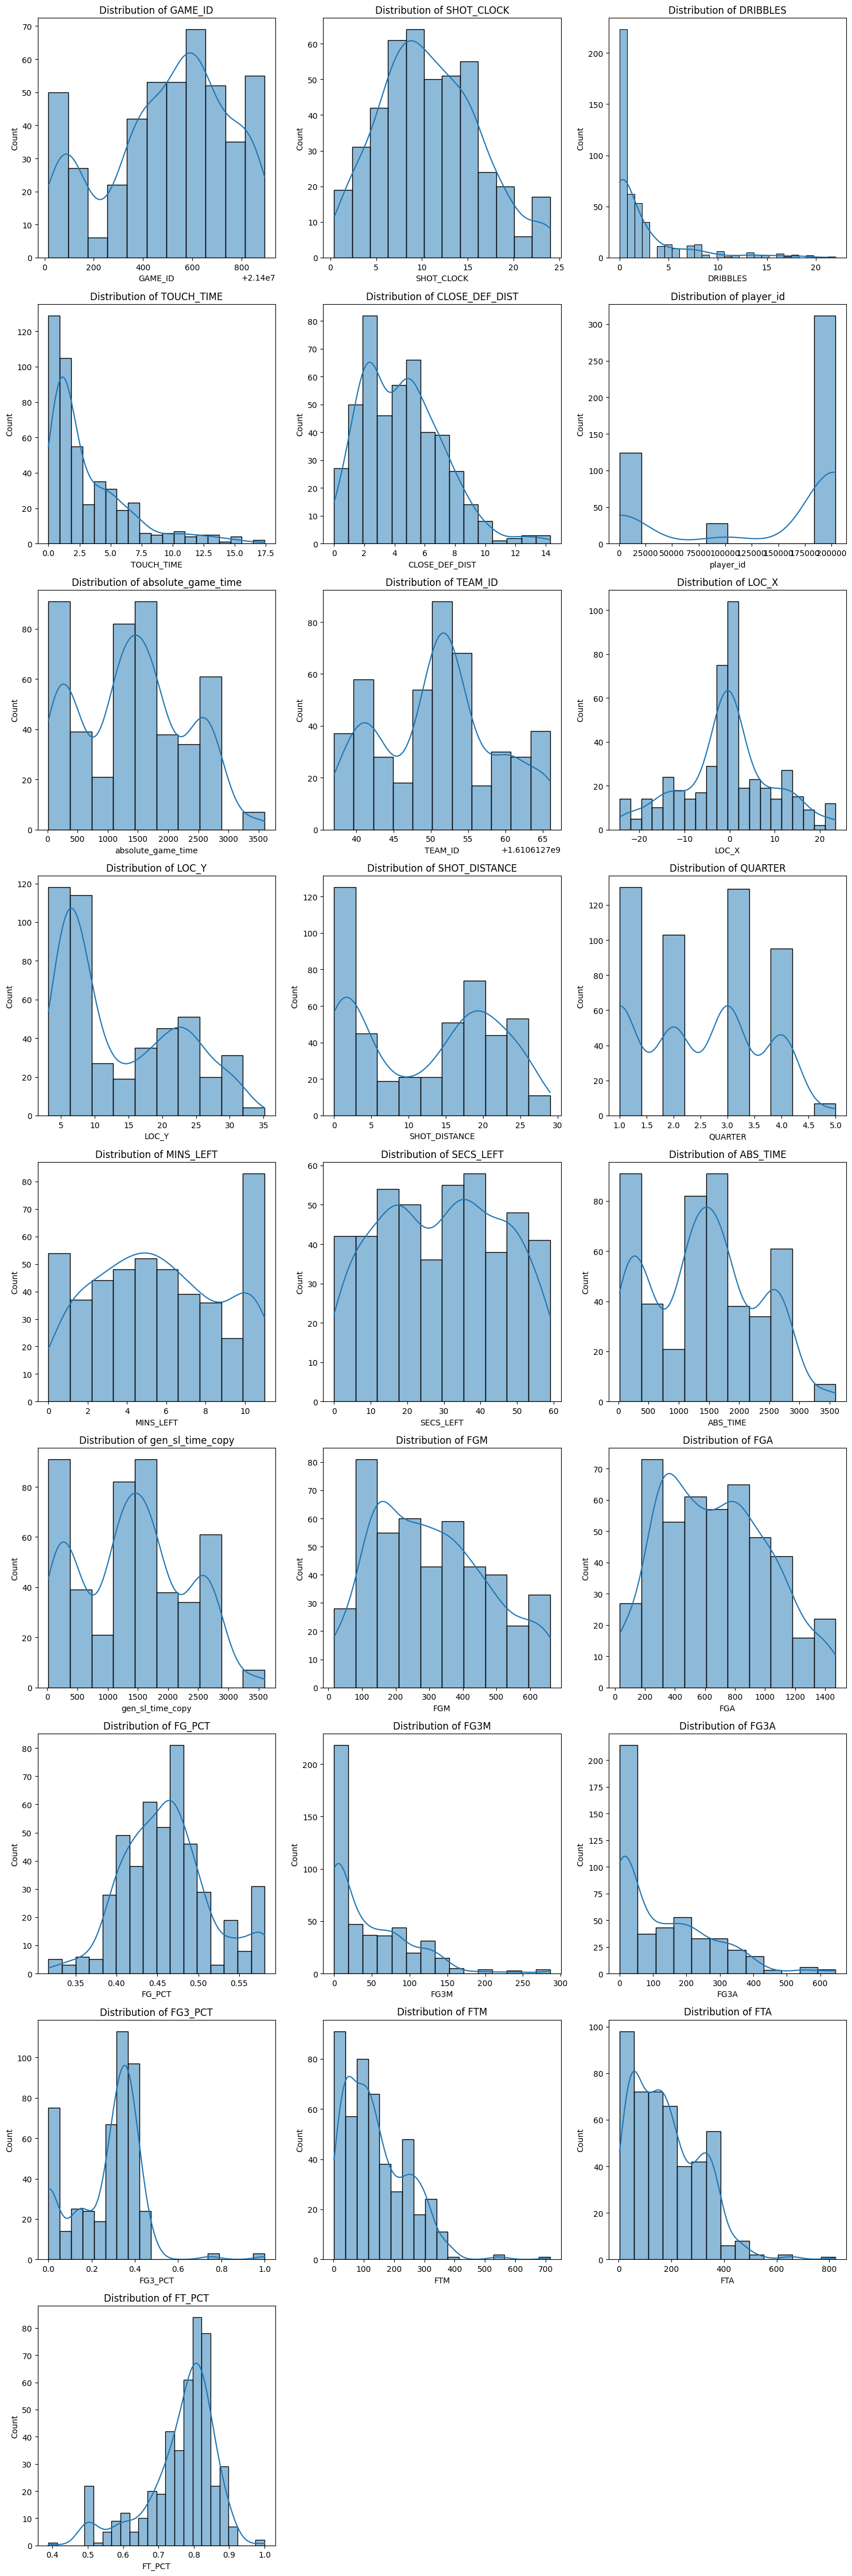

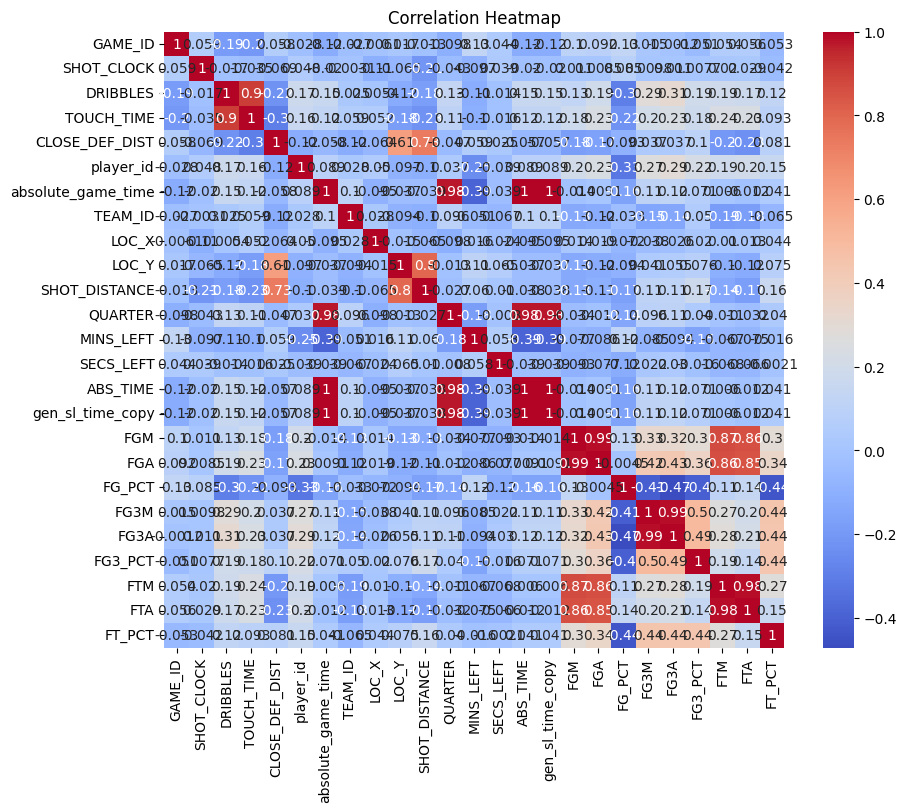

In [349]:
visualize_distributions(for_pred)

In [351]:
importlib.reload(du)
missing_summary = du.missing_values_summary(for_pred)
print(missing_summary)

            Missing Values  Percentage
SHOT_CLOCK              24    5.172414


In [352]:
# check for duplicate rows in the data for prediction
duplicate_rows = for_pred[for_pred.duplicated()]

# display the duplicate rows
print(duplicate_rows)

      GAME_ID  SHOT_CLOCK  DRIBBLES  TOUCH_TIME CLOSEST_DEFENDER  \
421  21400543         5.1         0         0.8             Nene   

     CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DIST  player_id  \
421                        2403             3.8       2200   

     absolute_game_time  SEASON_1  ... HEIGHT_defender  FGM   FGA  FG_PCT  \
421              2638.0    2015.0  ...            6-11  570  1153   0.494   

    FG3M FG3A FG3_PCT  FTM  FTA FT_PCT  
421   12   26   0.462  294  366  0.803  

[1 rows x 47 columns]


In [353]:
importlib.reload(du)
constant_columns = du.find_constant_columns(for_pred)
print("Columns with constant values:", constant_columns)

Columns with constant values: ['CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'SEASON_1', 'SEASON_2', 'HEIGHT_defender']


In [ ]:
# IMPLEMENT - DROP THE CONSTANT COLS, DEFINITELY SEASON_1

In [264]:
for_pred

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,absolute_game_time,SEASON_1,SEASON_2,TEAM_ID,PLAYER_ID,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,HEIGHT_attacker,HEIGHT_defender
0,NaN,0,5.2,2403,3.1,17.0,2015.0,2014-15,1.610613e+09,2200.0,...,L,8-16 ft.,14.6,4.75,14.0,1.0,11.0,40.0,7-0,6-11
1,9.8,0,1.1,2403,5.7,17.0,2015.0,2014-15,1.610613e+09,101112.0,...,LC,24+ ft.,9.5,29.65,26.0,1.0,11.0,41.0,7-0,6-11
2,2.9,1,1.7,2403,5.8,22.0,2015.0,2014-15,1.610613e+09,2544.0,...,C,24+ ft.,1.3,30.65,25.0,1.0,11.0,36.0,6-9,6-11
3,0.5,2,5.2,2403,0.1,25.0,2015.0,2014-15,1.610613e+09,2405.0,...,C,Less Than 8 ft.,0.7,5.35,0.0,1.0,11.0,37.0,6-10,6-11
4,8.5,2,2.8,2403,3.1,31.0,2015.0,2014-15,1.610613e+09,200746.0,...,R,8-16 ft.,-10.6,16.85,15.0,1.0,11.0,26.0,6-11,6-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,9.7,16,13.4,2403,2.0,3406.0,2015.0,2014-15,1.610613e+09,200768.0,...,C,Less Than 8 ft.,-1.3,5.85,1.0,5.0,3.0,11.0,6-0,6-11
374,6.1,6,4.8,2403,2.1,3417.0,2015.0,2014-15,1.610613e+09,201163.0,...,C,Less Than 8 ft.,-2.4,8.55,4.0,5.0,3.0,0.0,6-8,6-11
375,7.2,19,17.4,2403,5.2,3452.0,2015.0,2014-15,1.610613e+09,200768.0,...,LC,16-24 ft.,6.7,24.15,20.0,5.0,2.0,25.0,6-0,6-11
376,11.4,13,11.0,2403,5.1,3510.0,2015.0,2014-15,1.610613e+09,201951.0,...,RC,16-24 ft.,-14.4,16.75,18.0,5.0,1.0,28.0,5-11,6-11


In [ ]:
def preprocess_data(df, target_column=None):
    """
    Perform data preprocessing steps
    """
    # Separate features and target
    if target_column:
        X = df.drop(target_column, axis=1)
        y = df[target_column]
    else:
        X = df
        y = None
    
    # Handle missing values
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    # Numerical imputer
    num_imputer = SimpleImputer(strategy='mean')
    X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
    
    # Categorical imputer
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
    
    # Encode categorical variables
    encoders = {}
    for col in categorical_cols:
        encoders[col] = LabelEncoder()
        X[col] = encoders[col].fit_transform(X[col])
    
    # Scale numerical features
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    return X, y, encoders, scaler

In [44]:
bnk_pbp = playbyplayv3.PlayByPlayV3(game_id='0021400890').get_data_frames()[0]
bnk_pbp['ABS_TIME'] = bnk_pbp.apply(lambda row: du.clock_to_absolute_seconds(row['clock'], row['period']), axis=1)

In [45]:
bnk_pbp_shots = bnk_pbp[bnk_pbp.actionType.str.contains('shot', case=False)].reset_index(drop=True)


In [46]:
bnk_pbp_shots

,gameId,actionNumber,clock,period,teamId,teamTricode,personId,playerName,playerNameI,xLegacy,...,scoreAway,pointsTotal,location,description,actionType,subType,videoAvailable,shotValue,actionId,ABS_TIME
0,0021400890,2,PT11M44.00S,1,1610612747,LAL,201961,Ellington,W. Ellington,234,...,3,3,v,Ellington 24' 3PT Jump Shot (3 PTS) (Kelly 1 AST),Made Shot,Jump Shot,1,0,3,16.0
1,0021400890,3,PT11M29.00S,1,1610612766,CHA,201945,Henderson,G. Henderson,125,...,,0,h,MISS Henderson 18' Jump Shot,Missed Shot,Jump Shot,1,0,4,31.0
2,0021400890,5,PT11M14.00S,1,1610612747,LAL,203135,Sacre,R. Sacre,34,...,5,5,v,Sacre 17' Jump Shot (2 PTS) (Kelly 2 AST),Made Shot,Jump Shot,1,0,6,46.0
3,0021400890,6,PT10M56.00S,1,1610612766,CHA,2590,Williams,M. Williams,-163,...,,0,h,MISS Mo. Williams 20' Jump Shot,Missed Shot,Jump Shot,1,0,7,64.0
4,0021400890,8,PT10M43.00S,1,1610612747,LAL,203903,Clarkson,J. Clarkson,193,...,,0,v,MISS Clarkson 26' 3PT Jump Shot,Missed Shot,Jump Shot,1,0,9,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0021400890,476,PT00M31.90S,4,1610612766,CHA,201945,Henderson,G. Henderson,-142,...,,0,h,MISS Henderson 17' Jump Shot,Missed Shot,Jump Shot,1,0,428,2848.1
161,0021400890,478,PT00M22.80S,4,1610612747,LAL,201941,Hill,J. Hill,56,...,,0,v,MISS Hill 19' Jump Shot,Missed Shot,Jump Shot,1,0,430,2857.2
162,0021400890,510,PT00M09.00S,4,1610612747,LAL,203903,Clarkson,J. Clarkson,-2,...,98,199,v,Clarkson 1' Driving Layup (19 PTS) (Hill 2 AST),Made Shot,Driving Layup Shot,1,0,451,2871.0
163,0021400890,525,PT00M04.80S,4,1610612747,LAL,201941,Hill,J. Hill,7,...,100,203,v,Hill 1' Layup (10 PTS) (Johnson 3 AST),Made Shot,Layup Shot,1,0,460,2875.2


In [69]:
gen_sl_abs_times = set(game_gen_sl['ABS_TIME'].unique())
pbp_times = set(bnk_pbp_shots['ABS_TIME'].unique())

common_game_ids = gen_sl_abs_times.intersection(pbp_times)

print(f"Number of unique in gen_sl: {len(gen_sl_abs_times)}")
print(f"Number of unique in pbp: {len(pbp_times)}")
print(f"Number of common in both: {len(common_game_ids)}")

Number of unique in gen_sl: 100
Number of unique in pbp: 165
Number of common in both: 93


In [265]:
ap_1415_index = playerindex.PlayerIndex(season='2014-15').get_data_frames()[0]

In [267]:
ap_1415_index.columns

Index(['PERSON_ID', 'PLAYER_LAST_NAME', 'PLAYER_FIRST_NAME', 'PLAYER_SLUG',
       'TEAM_ID', 'TEAM_SLUG', 'IS_DEFUNCT', 'TEAM_CITY', 'TEAM_NAME',
       'TEAM_ABBREVIATION', 'JERSEY_NUMBER', 'POSITION', 'HEIGHT', 'WEIGHT',
       'COLLEGE', 'COUNTRY', 'DRAFT_YEAR', 'DRAFT_ROUND', 'DRAFT_NUMBER',
       'ROSTER_STATUS', 'FROM_YEAR', 'TO_YEAR', 'PTS', 'REB', 'AST',
       'STATS_TIMEFRAME'],
      dtype='object')

In [ ]:
ap_1415_index_for_join = ap_1415_index[['PERSON_ID', 'HEIGHT']]